# MRTS Sales Data ETL Project

**Umang Thanki**

# Index

- [Abstract](#Abstract)
- [1. Introduction](#1.-Introduction)
- [2. Extract-Transform-Load](#2.-Extract-Transform-Load)
    - [2.1 The ETL Process](#2.1-The-ETL-Process)
    - [2.2 Data Exploration](#2.2-Data-Exploration)
    - [2.3 Data Preparation](#2.3-Data-Preparation)
    - [2.4 Read the Data Using Python](#2.4-Reading-the-Data-Using-Python)
         - [2.4.1 Reading Sample Data](#2.4.1-Reading-Sample-Data)
         - [2.4.2 Reading the MRST Data](#2.4.2-Reading-the-MRST-Data)
    - [2.5 Writing an Installation Script](#2.5-Writing-an-Installation-Script)
- [3. Analysis and Visualization](#3.-Project-Description)
    - [3.1 Running Queries in MySQL Workbech](#3.1-Running-Queries-in-MySQL-Workbech)
    - [3.2 Running Queries From Python](#3.2-Running-Queries-From-Python)
    - [3.3 Explore Trends](#3.3-Explore-Trends)
    - [3.4 Explore Percentage Change](#3.4-Explore-Percentage-Change)
    - [3.5 Explore Rolling Time Windows](#3.5-Explore-Rolling-Time-Windows)
- [Conclusion](#Conclusion)
- [References](#References)

[Back to top](#Index)


##  Abstract

This project allows us to understand a given set of data, perform an Extract-Transform-Load (ETL) operation, and then analyze the data for insights. Concepts such as Trends, Percentage Changes, and Rolling Time Windows are discussed below and complemented with code and visual representations of the results of various queries.

[Back to top](#Index)


## 1. Introduction

In this project, we explore the Monthly Retail Trade Survey (MRTS) data set for the years 2020-1992 and perform an Extract-Transformation-Load (ETL) process through a variety of steps. We then analyze the data for trends, percentage changes, as well as rolling time windows paired with visualization for enhanced understanding of the data.

[Back to top](#Index)

## 2. Extract-Transform-Load

For each of the sections below, include a description of the steps you followed. Whenever possible, include screenshots of your code or program windows to demonstrate your steps.

[Back to top](#Index)

### 2.1 The ETL Process

The general process, outlined in more detail below, involves:

1. Reviewing the data in the MRTS spreadsheet and it's structure
2. Determining which data is relelvant for extraction
3. Transforming the relevant data in an appropriate way into a Data Frame
4. Compiling transformed data for all years (2020-1992) in a single Data Frame
5. Creating a database and table in MySQL programmatically via Python
6. Inserting the rows of the Data Frame into the MySQL table

[Back to top](#Index)

### 2.2 Data Exploration

The file used for the project is mrtssales92-present.xls. This spreadsheet has 30 sheets (2021-1992), although 2021 is excluded from our scope as the data is not representing a full year at the time the file was loaded. Initial research was done by exploring the [MRTS](https://www.census.gov/retail/index.html) website and its various tabs.

Each sheet has a similar structure. The first 4 and last 45 rows may be ignored, and the *Adjusted* section of the sheet may also be excluded. This leaves a *Not Adjusted* portion that has 15 columns (NAICS Code, kind of business, followed by month names of January through December, and ending with a Total summation column). Each cell under the month column headers corresponds to the value of sales for a specific type of business in a specific month time period for the year.

[Back to top](#Index)

### 2.3 Data Preparation

Manual modification was defintely possible to make to each sheet in the file, and such a step would be relatively simple given the uniform data structure from sheet to sheet. However, the purpose of ETL is to reduce manual labor and to automate as much as possible. For this reason, we will proceed by leaving the files in their original state and allow our code and logic to effectively perform ETL in the data. Such steps are detailed below.


[Back to top](#Index)

### 2.4 Read the Data Using Python

The way in which we can read a CSV file using Python is relatively simple. The following syntax should be used:

```
import csv

...

with open("file_name") as csv_file:
     csv_reader = csv.reader(csv_file, delimiter=",")
     for row in csv_reader:
         print(row)
```

[Back to top](#Index)

### 2.4.1 Reading Sample Data

In the early stages of the project, a sample file called test_csv.csv was used to experiment with the process detailed above. The file has the following structure:

```
first name,last name,age
John,Allen,48
Matthew,Jester,71
Michael,Wilson,50
```
After implementing the following Python code, we were able to read the data into the Visual Studio Code terminal:

```
import csv

with open("test_csv.csv") as csv_file:

    csv_reader = csv.reader(csv_file, delimiter=",")
    for row in csv_reader:
        print(row)
```

Since the file is a CSV file, meaning it is contains comma-separated values, it is crucial that we set the delimiter positional argument to `","`.


[Back to top](#Index)

### 2.4.2 Reading the MRTS Data

Although we explored CSV data initally and simply read the data into the Terminal, the MRTS dataset must be read and stored into a Pandas DataFrame as analysis must be conducted on the data. As a result, converting to CSV is also not required and we can simply use the Excel file format and programmatically read all of the data in the spreadsheet.

After the weeks Office Hours session, the following transformations were made to the data in the 2020 sheet:

1. Adding `import pandas as pd` to the top of the file
2. Reading the sheet into a Data Frame, skipping the first 4 and reading the next 67 rows
3. Dropping the first Unnamed column
4. Renaming the second Unnamed column to "Kind of Business"
5. Transposing the Data Frame
6. Replacing all "(S)" and "(NA)" entries with "0"
7. Remving NaN rows
8. Adding a DateTime column and converting the numeric values to Floats

Since this process was standard for every single sheet, we created a function at the top of the file and looped through every sheet to create a Data Frame that was appended to a list. Finally, the list was concatenated using `pd.concat()` which resulted in a single data Frame with all of the data in the desired format.

A snapshot of the function is provided below:
```
def add_dataframe(list_of_df, year):
    """Appends a DataFrame to a list that corresponds to the year of a specific sheet of the MRTS Sales Data."""
    df = pd.read_excel("mrtssales92-present.xls", sheet_name=year, skiprows=4, nrows=67)
    df.drop(["Unnamed: 0", "TOTAL"], axis=1, inplace=True)
    df.rename({"Unnamed: 1" : "Kind of Business"}, axis=1, inplace=True)
    df_trans = df.melt(id_vars="Kind of Business",value_vars=df.columns[1:])
    df_trans.replace("(S)", "0", inplace=True)
    df_trans.replace("(NA)", "0", inplace=True)
    df_trans.dropna(axis=0, inplace=True)
    df_trans["Period"] = "01 " + df_trans["variable"]
    df_trans["value"] = df_trans["value"].astype(float)
    df_trans = df_trans.astype({"Period" : "datetime64[ns]"})
    df_trans.drop("variable", axis=1, inplace=True)
    
    list_of_df.append(df_trans)

```
The function is then used in the code below to efficiently output a single Data Frame with all of the data:

```
list_df = []
years = []
year = 2020
while year >= 1992:
    years.append(str(year))
    year -= 1

for year in years:
    add_dataframe(list_df, year)
    
df_stacked = pd.concat(list_df)
df_stacked.reset_index(inplace=True)
df_stacked.drop("index", axis=1, inplace=True)
```

[Back to top](#Index)

### 2.5 Writing an Installation Script

Describe how you wrote a Python installation script to read your dataset in MySQL WorkBench.

Once the data was compiled into a single spreadsheet, it needed to be transferred to MySQL. This requires a secure connection to be made with a yaml file. This allows us to spearate the database access password from the code itself. Once the connection was established, we created a database called `mrtsdb` and a table called `mrts`, as shown below:

```
import yaml
import mysql.connector

...

db = yaml.safe_load(open("db.yaml"))
config = {
    "user":     db["user"],
    "password": db["pwrd"],
    "host":     db["host"],
    "auth_plugin":  "mysql_native_password"
}
cnx = mysql.connector.connect(**config)

MyCursor=cnx.cursor()
queries = []

# Creating the database and the table `mrts`
queries.append("DROP DATABASE IF EXISTS mrtsdb")
queries.append("CREATE DATABASE mrtsdb")
queries.append("USE mrtsdb")
queries.append("""CREATE TABLE mrts (
    kind_of_business VARCHAR (300) NOT NULL,
    value FLOAT NOT NULL,
    period DATE NULL) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4 COLLATE=utf8mb4_0900_ai_ci""")

for query in queries:
    MyCursor.execute(query)

```

This code creates the table and database. The next step is to insert every row of the Data Frame into the `mrts` table. To do this, the following code was implemented: 

```
for row_num in range(0, len(df_stacked)):
    row_data = df_stacked.iloc[row_num]
    value = (row_data[0], row_data[1], row_data[2])
    sql = "INSERT INTO mrts (kind_of_business, value, period) VALUES (%s, %s, %s)"
    MyCursor.execute(sql, value)

cnx.commit()

MyCursor.close()

cnx.close()
```

After executing all of the code in a single Python file, the following result is evident in the MySQL workbench:

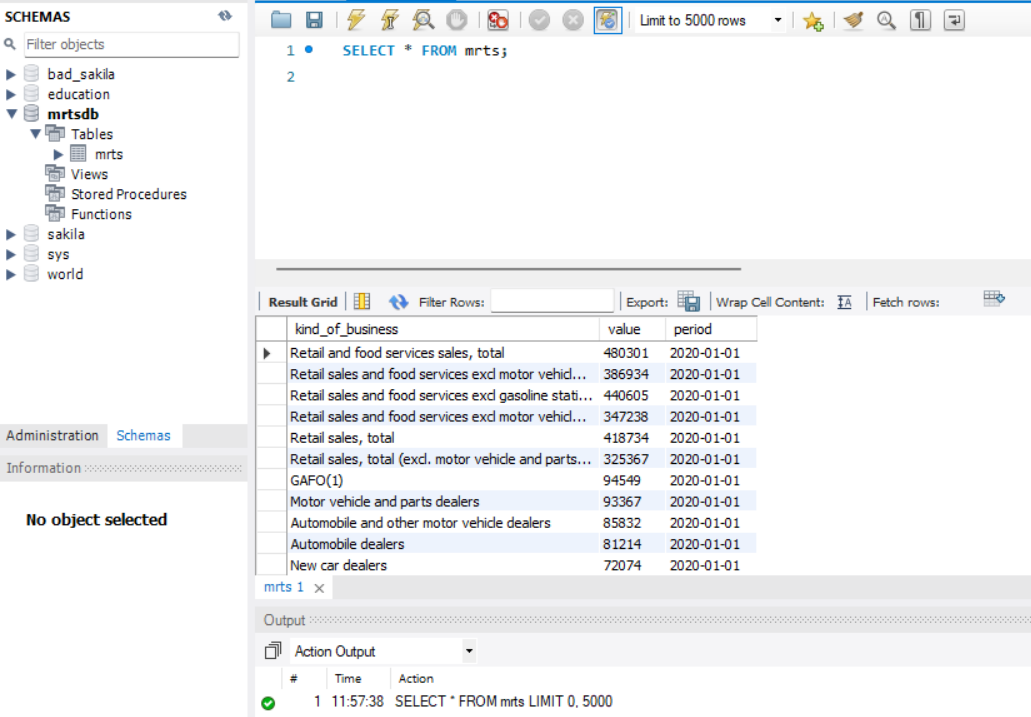


[Back to top](#Index)

## 3. Analysis and Visualization

The primary difference between running queries in the MySQL Workbench and in the Python environment is the means. The queries and their syntax are essentially the same but are executed in different ways. The advantage of running queries in the MySQL Workbench is that it is more direct and allows us to see the results quickly. On the other hand, the advantage of running queries in the Python environment is that we ca naccess the vast array of libraries that can assist us with analyzing and visualizing the data.

[Back to top](#Index)

### 3.1 Running Queries in MySQL Workbech


To verify that our ETL process was conducted properly and that data integrity was maintained, we ran two initial, basic queries in the MySQL Workbench:

1. `SELECT SUM(`value`) FROM mrts WHERE period = "2008-03-01";`
2. `SELECT `value` FROM mrts WHERE kind_of_business = "Health and personal care stores" AND period = "2015-06-01";`

The first query ensures all of the rows of data are accounted for if the sum is equal to the corresponding value in Excel; the second query draws a random value and shows the ETL process was done correctly if it matches the corresponding value in Excel.

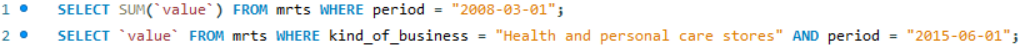

[Back to top](#Index)

### 3.2 Running Queries From Python
These queries were executed in Python by simply altering the code to include a query variable with the SELECT statement and running the query with the Cursor object, `MyCursor`.
```
query2 = "SELECT SUM(`value`) FROM mrts WHERE period = '2008-03-01'"
MyCursor.execute(query2)
for row in MyCursor.fetchall():
    print(row)

query3 = """SELECT `value` FROM mrts WHERE kind_of_business = 'Health and personal care stores' AND period = '2015-06-01';"""
MyCursor.execute(query3)
for row in MyCursor.fetchall():
    print(row)
```

These queries returned results that were equal to those in the MySQL Workbench, as expected. 

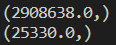

[Back to top](#Index)

### 3.3 Explore Trends

In my opinion, an economic trend represents the general growth, stagnation, or decay of a specific sector of the economy over a period of time. Such trends are important as they illustrate the performance of various industries both domestically and internationally, and helps predict future consumer spending behaviors.

When analyzing the trend of the `Retail and food services sales, total` kind of business from 1992-2020 from a monthly perspective, the plot was quite jagged. However, when switching to a yearly perspective, the trend was significantly cleaner and easier to understand:

```
query5 = """
SELECT SUM(`value`), YEAR(period) FROM mrts WHERE kind_of_business = 'Retail and food services sales, total'
GROUP BY 2 ORDER BY period
"""
MyCursor.execute(query5)
```

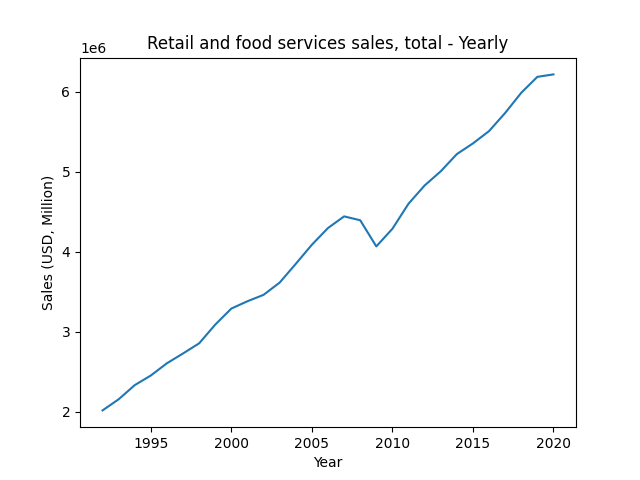

If we limit our focus to the bookstores, sporting goods stores, and hobbies, toys, and games stores businesses, the highest trend can be seen in the sprting goods stores business. This business was also the one that grew the fastest has it had the higest slope over the time period analyzed. From a Monthly perspective, the sales increase during the holiday seasons, typically in November and December. Based on the data, the yearly trend is more reliable as it illustrates the growth of each business over time and negates the effects of seasonal demand.

Although the second figure below shows year tick marks, zooming into the plot in Python would should monthly ticks.

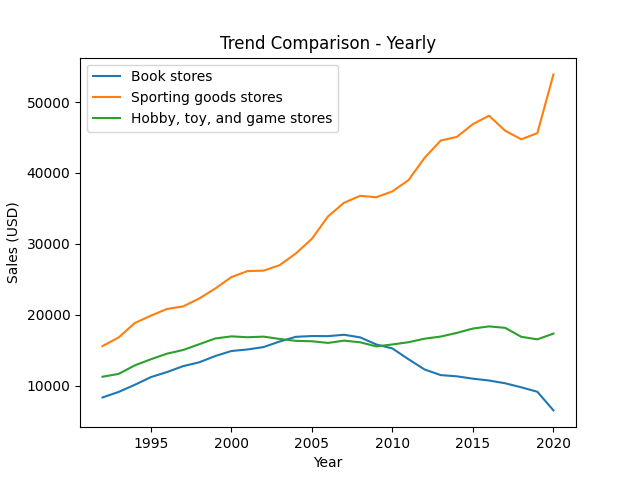

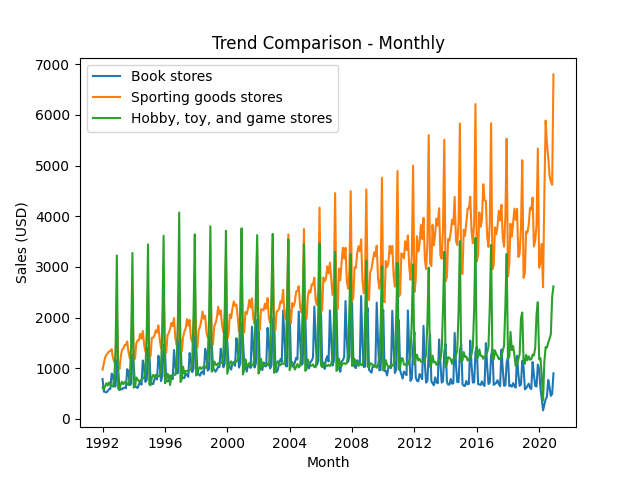

[Back to top](#Index)

### 3.4 Explore Percentage Change

Percentage change is the change in a percentage format from an initial value to a final value. The formula dividing the difference of the new and old value by the old value. AS a result, percentage change can be negative. This is important as it not only illustrates positive or negative trends in the economy, but also measures the magnitude of change periodically, whether it is monthly or yearly.

For example, let's consider the Men's clothing stores and Women's clothing stores businesses. They are related as they are part of the same industry - clothing. To understand the yearly percentage changes for these two businesses, we opted to use Python as data Frames offer a percent change function,`pct_change()`.

The following code was used to derive the plot:
```
df_mens_stores = df_stacked[df_stacked["Kind of Business"] == "Men's clothing stores"].copy()
df_mens_stores["Year"] = pd.DatetimeIndex(df_mens_stores["Period"]).year
mens_pct = df_mens_stores.groupby("Year").agg({"value" : "sum"}).pct_change()

df_womens_stores = df_stacked[df_stacked["Kind of Business"] == "Women's clothing stores"].copy()
df_womens_stores["Year"] = pd.DatetimeIndex(df_womens_stores["Period"]).year
womens_pct = df_womens_stores.groupby("Year").agg({"value" : "sum"}).pct_change()

combined_df = pd.DataFrame()
combined_df["Men's Clothing Stores Sales"] = mens_pct["value"].copy()
combined_df["Women's Clothing Stores Sales"] = womens_pct["value"]
combined_df.plot(title="Percent Change", ylabel="% Change")
plt.show()
```

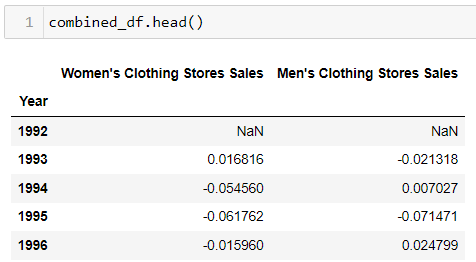

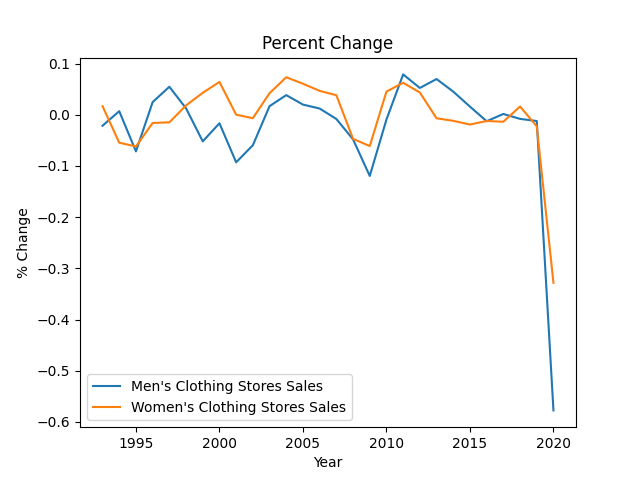

From year to year, the contribution of Men's sales in percentage form can be understood by running the following code in Python:

```
df_mens_stores = df_stacked[df_stacked["Kind of Business"] == "Men's clothing stores"].copy()
df_mens_stores["Year"] = pd.DatetimeIndex(df_mens_stores["Period"]).year
df_womens_stores = df_stacked[df_stacked["Kind of Business"] == "Women's clothing stores"].copy()
df_womens_stores["Year"] = pd.DatetimeIndex(df_womens_stores["Period"]).year

mens_sales = df_mens_stores.groupby("Year").agg({"value" : "sum"})
womens_sales = df_womens_stores.groupby("Year").agg({"value" : "sum"})
combined_sales = mens_sales.copy()
combined_sales.rename({"value":"Men's Sales"}, axis=1, inplace=True)
combined_sales["Women's Sales"] = womens_sales["value"]
combined_sales["Total"] = combined_sales["Men's Sales"] + combined_sales["Women's Sales"]
combined_sales["Men's Percentage (%)"] = round((combined_sales["Men's Sales"]/combined_sales["Total"])*100, 2)
combined_sales["Men's Percentage (%)"].plot(title="Men's Sales Percentage of Total", xlabel="Year", ylabel="Percentage, %")
plt.show()
```

This yields the following plot. The percentage contribution of Women's clothing store sales is simply the difference between 100% and the plotted value for a given year.

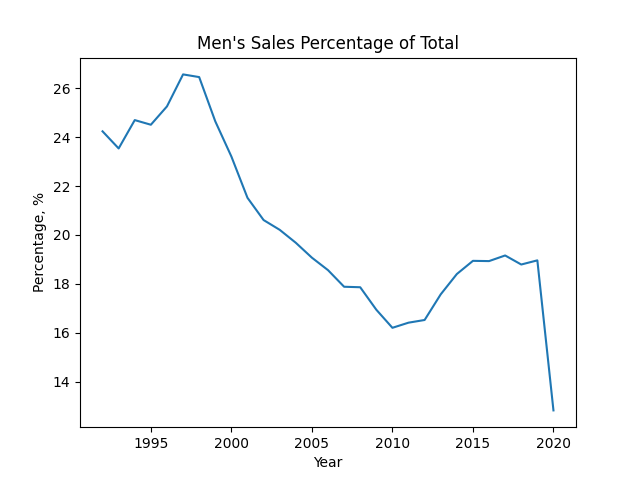

[Back to top](#Index)

### 3.5 Explore Rolling Time Windows

In my opinion, a rolling window is important in economics as it shows various metrics and their perofmance over a specific time interval in the past that is continuously proceeding. This can behelpful in our specific ssituation as it helps us to better understand business perfomance with respect to sales.

- Consider at least two businesses of your own from the MRTS data. Which *queries* did you write to analyze and produce graphs of rolling time windows for the chosen categories?

The first rolling window query executed on the New Car Dealer business, programmatically, is shown below:

```
query9a = """
SELECT period, SUM(`value`) OVER(ORDER BY period) AS rolling_sum FROM mrts WHERE kind_of_business = "New car dealers" AND YEAR(period) = "2020";"""
MyCursor.execute(query9a)
Month = []
cumulative_sales = []
for row in MyCursor.fetchall():
    Month.append(row[0])
    cumulative_sales.append(row[1])
plt.plot(Month, cumulative_sales)
plt.title("New Car Dealers, 2020 Cumulative Sales")
plt.xlabel("Month")
plt.ylabel("Cumulative Sales (USD)")
plt.show()
```
This produced the following graph:
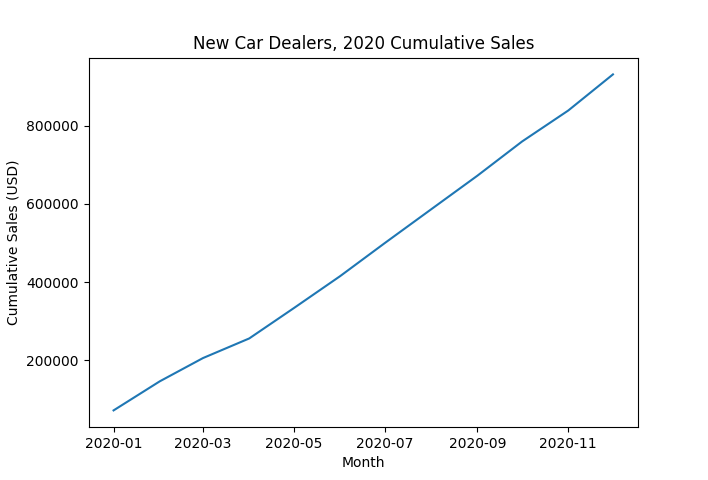

The next rolling window query executed programmatically was related to the 6-month rolling mean for Gasoline Stations in the period 2000-2008, as shown below:

```
query9b = """
SELECT period, AVG(`value`) OVER(ORDER BY period ROWS BETWEEN 5 PRECEDING AND CURRENT ROW) AS rolling_average FROM mrts WHERE kind_of_business = 'Gasoline stations' and period BETWEEN '2000-01-01' and '2008-12-01'"""
MyCursor.execute(query9b)
Month = []
average6mo_sales = []
for row in MyCursor.fetchall():
    Month.append(row[0])
    average6mo_sales.append(row[1])
plt.plot(Month, average6mo_sales)
plt.title("Gasoline Stations, Last 6-months Average Sales, 2000-2008")
plt.xlabel("Month")
plt.ylabel("Last 6-months Average Sales (USD)")
plt.show()
```

This produced the following graph:
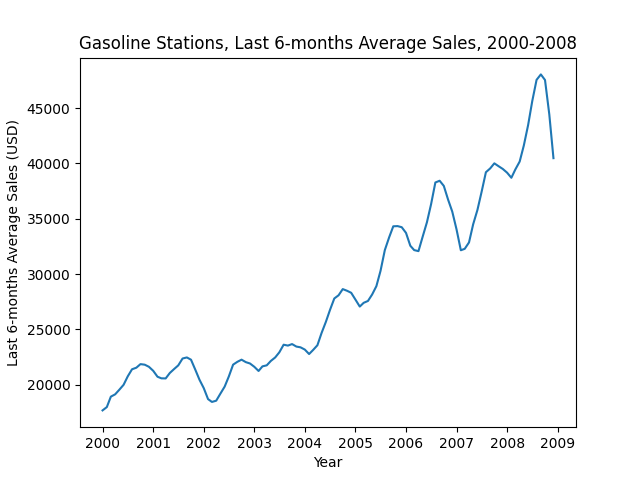

[Back to top](#Index)

## Conclusion

Based on the data, a simple query illustrates where these businesses are in terms of the sales performance with resepct to one another:

`SELECT kind_of_business, SUM(`value`) AS total_sales FROM mrts GROUP BY kind_of_business ORDER BY `value` DESC;`

Based on the results, it appears Retail and Food Services will attract the highest spending, while Drinking Places will not attract much spending moving forward.




[Back to top](#Index
)
## References

“Windowing Operations¶.” Windowing Operations - Pandas 1.4.2 Documentation, https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html. 

Otwell, Joshua. “Rolling Sum and Average - Window Functions Mysql.” Digital Owl's Prose, 7 Nov. 2020, https://joshuaotwell.com/rolling-sum-and-average-with-window-functions-in-mysql/. 

“Python: Pandas Dataframe.pct_change().” GeeksforGeeks, 22 Nov. 2018, https://www.geeksforgeeks.org/python-pandas-dataframe-pct_change/. 

freeCodeCamp.org. “How to Format Code in Markdown.” FreeCodeCamp.org, FreeCodeCamp.org, 28 Apr. 2021, https://www.freecodecamp.org/news/how-to-format-code-in-markdown/. 

“Extract Month and Year to a New Column in Pandas: Data Interview Questions.” Extract Month and Year to a New Column in Pandas | Data Interview Questions, https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas. 

“Python: Pandas Extracting Rows Using .Loc[].” GeeksforGeeks, 30 Sept. 2019, https://www.geeksforgeeks.org/python-pandas-extracting-rows-using-loc/. 

“Relative Change and Difference.” Wikipedia, Wikimedia Foundation, 28 Apr. 2022, https://en.wikipedia.org/wiki/Relative_change_and_difference. 